In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load

%matplotlib inline

/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
path="/Users/kyradresen/MasterThesis_MedTextPrivacy/data/0507_mtsamples_final.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(2016, 26)


,Unnamed: 0,medical_specialty,transcription,age_related_sentence,extracted_text,word_count,med_masked_transcriptions,pii_masked_transcriptions,synthetic_sentence_nodp_temp0.6_topk50,synthetic_sentence_eps16_temp0.6_topk100,...,synthetic_sentence_nodp_temp1.0_topk100,synthetic_sentence_nodp_temp0.8_topk100,synthetic_sentence_nodp_temp0.6_topk100,synthetic_sentence_eps3_temp0.6_topk100,synthetic_sentence_eps3_temp0.8_topk100,synthetic_sentence_eps3_temp1.2_topk100,synthetic_sentence_eps3_temp1.2_topk50,synthetic_sentence_eps3_temp1_topk50,synthetic_sentence_eps3_temp0.8_topk50,synthetic_sentence_eps3_temp0.6_topk50
0,0,Neurology,"CC:, Confusion and slurred speech.,HX , (prima...","HX , (primarily obtained from boyfriend): This...",(primarily obtained from boyfriend): This 31 y...,43,(primarily obtained from boyfriend): This[AGE]...,(primarily obtained from boyfriend): This[AGE]...,The patient is a 55-year-old Caucasian female ...,The patient is a 38-year-old Caucasian male ag...,...,The patient presents to the patient has been s...,A 16-year-old female who was referred for our ...,The patient was brought to the operating room ...,HISTORY OF PRESENT ILLNESS: The patient is a 3...,"Pulmonary[SEP/H]After a consultation, the pati...",This is the history of multiple minor neurolog...,"According to the patient:The patient, an invas...",Orththroteonthroxy[SEPSEP][SEPES/H]The patient...,Gastroenterology[SEP.]The patient was a 22-yea...,The patient is a man who was treated to a card...
1,1,Cardiovascular/Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...","INDICATIONS FOR SURGERY,The patient is a 50-ye...",The patient is a 50-year-old white male with h...,72,The patient is a[AGE] white[SEX] with history ...,The patient is a[AGE] white[SEX] with history ...,This is a 74-year-old boy who presented to the...,The patient was brought to the hospital with a...,...,The patient received a 13 cm x 4 cm diameter. ...,After informed consent was obtained was brough...,The patient was brought to the operating room ...,The patient is a 13-year-old female who has ha...,The patient who has suffered a serious neck pa...,This is an annual consultation with an adult-s...,.There is an ongoing patient history of bilate...,"Orthopedolosis,PESIAT, a health history for a ...","HISTORY OF PRESENT PRESENT:,The patient is a 2...",The patient is a 37-year-old who is a cardiac-...
2,2,Urology,"PROCEDURE: , Elective male sterilization via b...","PROCEDURE: , Elective male sterilization via b...",Elective male sterilization via bilateral vase...,43,Elective male sterilization via bilateral vase...,Elective male sterilization via bilateral vase...,"HISTORY OF PRESENT ILLNESS:, This is a 51-year...","Cardiovascular/Pulmonary[SEP:],HISTORY OF PRES...",...,The patient's room and brought to the operatin...,The patient was brought to the operating room ...,The patient is a 53-year-old white male with a...,The patient is a 91-year-old male with a histo...,The patient was done with a significant heart ...,The patient is well health at the operating ar...,"From this article, Dr. I have stated that her ...","PANIMA/PES/PROCES,P,This is a patient with the...",The patient is a 25-year-old male who is in a ...,The patient is a 39-year-old man who is diagno...
3,3,Urology,"DESCRIPTION:, The patient was placed in the s...","DESCRIPTION:, The patient was placed in the su...",The patient was placed in the supine position ...,44,The patient was placed in the supine position ...,The patient was placed in the supine position ...,The patient was brought to the operating room ...,The patient with a history of prostate cancer....,...,"The patient tolerated the procedure well.,2, a...",This is a 52-year-old male who fell to have a ...,The patient was brought in the operating room ...,The patient is a 2-year-old male who had under...,:PANOCFETERI: An patient is a 20-year-old woma...,This is a 26-year-old couple who lives for a 2...,The patient is 5. OF OF PRESESTES AND TREASIAT...,;

## Remove the concetenated Target Variable for the synthetic differentially private text

In [95]:
import pandas as pd
import re

def remove_before_sep(df, start_col):
    """
    Removes everything before '[SEP]' in the specified columns of the DataFrame starting from a given column index.

    Parameters:
    - df: DataFrame containing the data.
    - start_col: The index of the column to start processing from.

    Returns:
    - df: DataFrame with the processed columns.
    """
    # Define the regular expression pattern to match everything before '[SEP]'
    pattern = re.compile(r'.*?\[SEP\]') 

    # Apply the regular expression to each column starting from start_col
    for column_name in df.columns[start_col:]:
        df[column_name] = df[column_name].apply(lambda x: re.sub(pattern, '', str(x)))

    return df

In [ ]:
df = remove_before_sep(df, 4)

## Print Sentence at index

In [ ]:
# Function to print sentences and medical specialty at a specific index for the given columns
def print_sentences_and_specialty_at_index(df, index, columns, specialty_column):
    if index < len(df):
        medical_specialty = df[specialty_column].iloc[index]
        print(f"Medical Specialty: {medical_specialty}")
        for column in columns:
            print(f"Sentence in column '{column}' at index {index}: {df[column].iloc[index]}")
    else:
        print(f"Index {index} is out of bounds for the dataframe.")

# Columns to apply the remove_before_sep function
columns_to_clean = [
    'synthetic_sentence_nodp_temp0.6_topk50',
    'synthetic_sentence_eps16_temp1_topk50',
    'synthetic_sentence_eps8_temp1_topk100',
    'synthetic_sentence_eps3_temp1_topk100',
    'synthetic_sentence_nodp_temp0.8_topk50',
    'synthetic_sentence_nodp_temp1.0_topk50',
    'synthetic_sentence_nodp_temp1.2_topk50',
    'synthetic_sentence_nodp_temp1.2_topk100',
    'synthetic_sentence_nodp_temp1.0_topk100',
    'synthetic_sentence_nodp_temp0.8_topk100',
    'synthetic_sentence_nodp_temp0.6_topk100',
    'synthetic_sentence_eps3_temp0.6_topk100',
    'synthetic_sentence_eps3_temp0.8_topk100',
    'synthetic_sentence_eps3_temp1.2_topk100',
    'synthetic_sentence_eps3_temp1.2_topk50',
    'synthetic_sentence_eps3_temp1_topk50',
    'synthetic_sentence_eps3_temp0.8_topk50',
    'synthetic_sentence_eps3_temp0.6_topk50'
]

# Apply the remove_before_sep function to
for column in columns_to_clean:
    df = remove_before_sep(df, column)

# Example usage: print sentences at a specific index (e.g., index 5)
specific_index = 1
print_sentences_and_specialty_at_index(df, specific_index, columns_to_clean, column)

Medical Specialty: The patient is a 37-year-old who is a cardiac-old who has seen a cardiac-free. He is a 25-year-year-term-old who had a heart-free. She is a 37.5-year-SEP with a history of low-dose meth. She is also a
Sentence in column 'synthetic_sentence_nodp_temp0.6_topk50' at index 1: This is a 74-year-old boy who presented to the hospital for a history of an outpatient history of bleeding and had a history of uterine and urethra. She was diagnosed with a history of chronic vaginal discharge. The patient states that she was admitted to the left breast and then then he had a right breast mass
Sentence in column 'synthetic_sentence_eps16_temp1_topk50' at index 1: The patient was brought to the hospital with an X4G MRI-based patient placed with a BIP. The patient was placed in a fashionable fashion for the procedure. He was placed in the general operating room. The patient showed no neurological disease. The patient had been diagnosed with persistent problems in the usual procedure 

## Distribution of Target Variable 

In [98]:
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)

medical_specialty
Cardiovascular/Pulmonary    325
Orthopedic                  310
Neurology                   287
Urology                     212
Gastroenterology            200
Radiology                   167
Obstetrics/Gynecology       143
Otolaryngology               90
Hematology-Oncology          89
Ophthalmology                74
Pediatrics-Neonatal          69
Psychiatry/Psychology        50
Name: count, dtype: int64


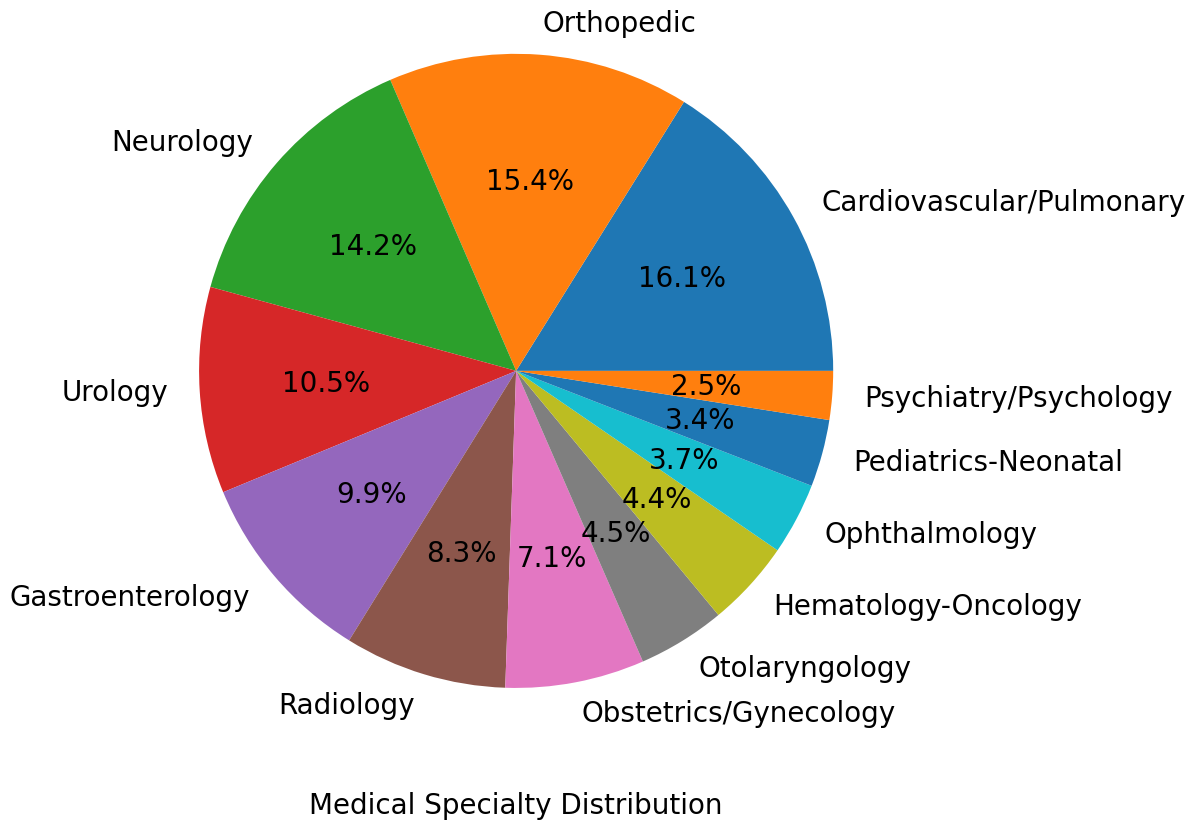

In [309]:
plt.figure(figsize=(9,9))

# Increase title size
plt.title('Medical Specialty Distribution', fontsize=20, y=-0.15)

# Increase the font size of the labels and autopct
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%", textprops={'fontsize': 20})

plt.axis('equal')
plt.show()

## Embeddings

In [ ]:
df.columns

Index(['medical_specialty', 'transcription', 'age_related_sentence',
       'extracted_text', 'word_count', 'med_masked_transcriptions',
       'pii_masked_transcriptions', 'synthetic_sentence_nodp_temp0.6_topk50',
       'synthetic_sentence_eps16_temp1_topk50',
       'synthetic_sentence_eps8_temp1_topk100',
       'synthetic_sentence_eps3_temp1_topk100',
       'synthetic_sentence_nodp_temp0.8_topk50',
       'synthetic_sentence_nodp_temp1.0_topk50',
       'synthetic_sentence_nodp_temp1.2_topk50',
       'synthetic_sentence_nodp_temp1.2_topk100',
       'synthetic_sentence_nodp_temp1.0_topk100',
       'synthetic_sentence_nodp_temp0.8_topk100',
       'synthetic_sentence_nodp_temp0.6_topk100',
       'synthetic_sentence_eps3_temp0.6_topk100',
       'synthetic_sentence_eps3_temp0.8_topk100',
       'synthetic_sentence_eps3_temp1.2_topk100',
       'synthetic_sentence_eps3_temp1.2_topk50',
       'synthetic_sentence_eps3_temp1_topk50',
       'synthetic_sentence_eps3_temp0.8_topk50',

In [298]:
from transformers import RobertaTokenizer, RobertaModel

# Ensure 'transcription' is of type string
df['synthetic_sentence_eps3_temp0.6_topk100'] = df['synthetic_sentence_eps3_temp0.6_topk100'].astype(str)

# Define X and y
X = df['synthetic_sentence_eps3_temp0.6_topk100'].tolist()
y = df['medical_specialty'].tolist()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Assuming 'device' is defined (usually 'cuda' or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tokenize X
inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=256)

# Generate embeddings in batches
def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in range(0, inputs['input_ids'].size(0), batch_size):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Generate embeddings
embeddings = generate_embeddings(model, inputs, batch_size=16)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Split: Train, Validation, Test

In [221]:
#store the original test dataset from OG extracted_sentence

X_test_OG = X_test
y_test_OG = y_test

In [299]:
# Split the data into training and test sets (70% training, 30% testing/validation)
X_train, X_temp, y_train, y_temp = train_test_split(embeddings, y, test_size=0.30, random_state=42, stratify=y)

# Further split the test/validation set into validation and test sets (50% validation, 50% testing)
X_val, X_test_nonOG, y_val, y_test_nonOG = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

### OverSampling: SMOTE

In [301]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with a specific random state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE to the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

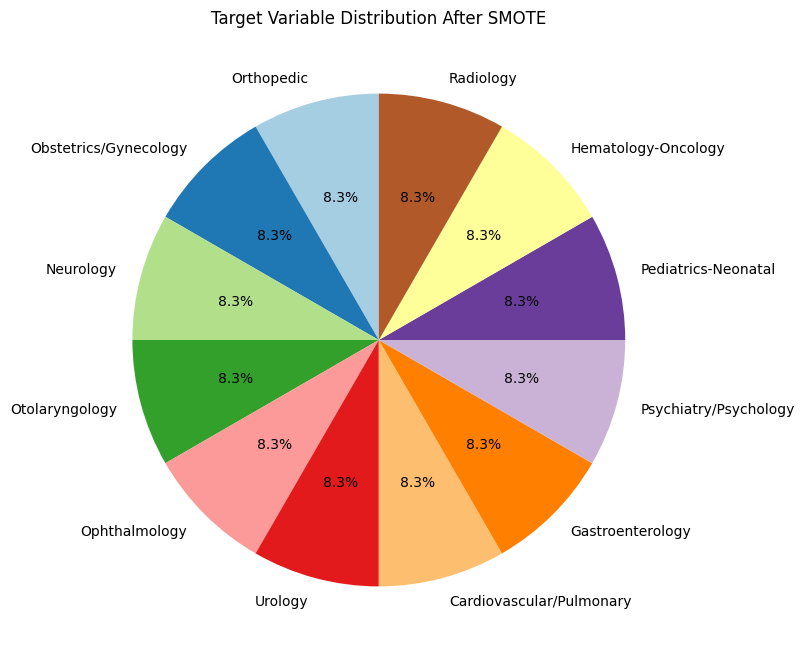

In [302]:
# Create a dataframe for the resampled data to facilitate plotting
resampled_df = pd.DataFrame(y_train_resampled, columns=['medical_specialty'])

# Plot a pie chart of the target variable distribution after SMOTE
label_counts = resampled_df['medical_specialty'].value_counts()
plt.figure(figsize=(8, 8))
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Target Variable Distribution After SMOTE')
plt.ylabel('')  # Hide the y-label for better visual appeal
plt.show()

## Random Forrest Classification

In [303]:

# Define the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}


# Define the Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the Grid Search model
grid_search.fit(X_train_resampled, y_train_resampled)

# Save the trained Grid Search model
dump(grid_search, 'grid_search_rf.joblib')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, min_sam

['grid_search_rf.joblib']

In [304]:
from sklearn.metrics import classification_report

# load the trained gridsearchcv object
grid_search = load('grid_search_rf.joblib')

# Predicting on the test
y_pred = grid_search.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))
report = classification_report(y_test, y_pred, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set:
                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.22      0.90      0.35        49
        Gastroenterology       0.00      0.00      0.00        30
     Hematology-Oncology       0.00      0.00      0.00        14
               Neurology       0.38      0.07      0.12        43
   Obstetrics/Gynecology       0.08      0.27      0.12        22
           Ophthalmology       0.00      0.00      0.00        11
              Orthopedic       0.31      0.09      0.13        47
          Otolaryngology       0.00      0.00      0.00        13
     Pediatrics-Neonatal       0.00      0.00      0.00        10
   Psychiatry/Psychology       0.00      0.00      0.00         7
               Radiology       0.00      0.00      0.00        25
                 Urology       0.00      0.00      0.00        32

                accuracy                           0.19       303
               macro avg       0.08    

/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use